Как Вы уже знаете (если не знаете, рекомендуем посмотреть [5-ую](https://www.youtube.com/watch?v=cAJp2hh-_q8&t=4831s) и [6-ую](https://www.youtube.com/watch?v=RVk2RUW9Euk&t=40s) лекции нашего курса), в современных задачах обработки изображений, будь то задача обнаружения объектов, задача распознавания образов, задача (семантической) сегментации, задача классификации изображений и другие, всё чаще используют **свёрточные нейросети** (*Convolutional Neural Networks*, *CNN*).

Они показывают очень хорошие результаты, за ними стоит как [математический аппарат](https://stats.stackexchange.com/questions/269854/are-there-mathematical-reasons-for-convolution-in-neural-networks-beyond-expedie), так и эвристики, полученные опытным путём.


В данном задании Вам предстоит познакомиться с архитектурами *AlexNet*, *VGG* и *Inception* и для каждой из этих моделей использовать технику **Transfer Learning**.

###  Transfer Learning
Процесс дообучения на **новых данных** какой-либо нейросети, уже обученной до этого на других данных, обычно на каком-нибудь хорошем, большом (миллионы картинок) датасете (например, [ImageNet](http://www.image-net.org/) ~ 14 млн картинок).

Теперь мы перейдем к тому, как можно использовать уже обученные нейросети, чтобы ускорить свою работу.
Давайте вспомним общую архитектуру CNN:
<img src="https://camo.githubusercontent.com/42e58bc7c5322749795810f139f299b9b645aed07b92b8ac3b3e53df48067e4d/68747470733a2f2f64726976652e676f6f676c652e636f6d2f75633f69643d31347041704b71516a6e6d574d58617a593048486a52456e397249397577435167">

С помощью операций *свёртки (convolution)* и *пулинга (pooling)* всё, что расположено до этапа *classification*, по сути **извлекает признаки из объектов, подающихся на вход** (картинок, в данном случае). То есть вместо того, чтобы самим пытаться как-то описать картинки для хорошей работы классификатора, мы предоставляем заняться этим нейросети (обучая её методом обратного распространения ошибки ([лекция 4](https://www.youtube.com/watch?v=HZDOhHAg5_g))).

**Вопрос (творческий):**  А какие признаки для картинок приходят Вам в голову? (считать, что картинки цветные (3 канала), все одинакового размера)

**Ответ:** <Ваши мысли>

<h2 style="text-align: center;"><b>Описание метода</b></h3>

Представим теперь, что eсть свой набор данных, и Вы хотите научить сеть классифицировать объекты из Вашей выборки.
Есть 4 возможных подхода к задаче:

* **1. Написать свою собственную нейронную сеть**
    * Если Вас зовут не Ian Godfellow, Geoffry Hinton или Andrew Ng, то не рекомендуется пользоваться этим способом
    * May the force be with You

* **2. CNN как средство для извлечения признаков (Feature Extractor)**
    * Берём сетку, обученную на ImageNet
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию. Веса предыдущих слоёв **заморожены**, мы их не трогаем. Теперь сеть выдаёт не метки классов, а то, что поступало на вход Fully-Connected (развёрнутый в строку "параллелепипед" HxWxNUM_FILTERS с последнего слоя перед FC)
    * Запускаем сеть на новом датасете, получаем выходы сети для всех объектов - это и есть их признаки, полученные сетью
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете

* **3. CNN, которую можно дообучить (Fine Tuning)**
    * Берём сетку, обученную на ImageNet
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.
    * Теперь всё же *распространяем backpropagation ещё на сколько-то слоёв назад (размораживаем веса в этих слоях)*, чтобы скорректировать их под новые данные. Можно распространить обучение и на всю сеть, но часто первые слои всё же замораживают, поскольку они (как ожидается) извлекают более общие признаки. А ещё обучать всю сеть всё же дольше, чем несколько слоёв. Всё зависит от того, какого качества Вы хотите добиться
    * Теперь сеть выдаёт не метки классов, а то, что поступало на вход Fully-Connected (веса последних (или всех) слоёв были изменены под наши данные)
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете

* **4. Использовать предобученную модель "из коробки"**
    * То есть взять уже готовую нейронную сеть и использовать её (её параметры (W, b..), ведь сеть характеризуется параметрами, если архитектура известна) для решения своей задачи. Например, [здесь](https://github.com/BVLC/caffe/wiki/Model-Zoo) люди часто выкладывают веса моделей, обученных для решения их специфических задач.


В зависимости от количества и природы Ваших данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* *У Вас **мало данных** ($\le$ 10k), и они **похожи** на данные, на которых была обучена сеть до этого*
Если данные совсем похожи, можно попробовать использовать готовую модель. Если качество Вас не устраивает, то тогда стоит использовать CNN для извлечения признаков и обучить свой классификатор на этих данных (2-ой способ выше). Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning (3 способ), то сеть может переобучиться, поскольку данных мало.
* *У Вас **мало данных** ($\le$ 10k), и они **не похожи** на данные, на которых была обучена сеть до этого*
Самый невыгодный случай. Здесь мы не можем ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует также действовать в соответствие со 2-ым способом, но брать как признаки выходы более ранних слоёв, ведь, как мы помним, они (как ожидается) соответствуют более общим паттернам в данных.
* *У Вас **много данных** ($\ge$ 10k), и они **похожи** на данные, на которых была обучена сеть до этого*
В этом случае можем смело делать Fine-Tuning (3 способ) (если не устроило качество модели "из коробки"), ведь данных много, и вероятность переобучения меньше. В данном случае имеет смысл попробовать разморохить веса последних нескольких слоёв (зависит от того, сколько у Вас времени и вычислительной мощности, можно разморозить и всю сеть)
* *У Вас **много данных** ($\ge$ 10k), и они **не похожи** на данные, на которых была обучена сеть до этого*
В принципе, подход тот же, что и в случае похожих данных, то есть мы файнтюним практически всю нейросеть. Однако мы вольны в этом случае полнстью менять все параметры (и гиперпараметры) нейросети, ведь по сути мы пользуемся только её архитектурой, забывая о том, что она уже была когда-то обучена. Но часто веса предобученной сети оставляют в качестве инициализации для обучения на новых данных.

Надеемся, что теперь Вам стало понятнее, как обучать крутые сети на новых данных.

<h2 style="text-align: center;"><b>Переходим к практике</b></h3>

<p style="text-align: center;"><i>(основано на http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)</i></p>

In [2]:
import os
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

### В чём состоит задание

Вам предстоит попробовать использовать  типа архитектур свёрточных нейросетей - **AlexNet (сделано за Вас в примере), VGG16, Inception_v3** - как *Feature Extractor*, с помощью *Fine Tuning* и *"из коробки"*.

**Для каждого пункта нужно:**
- вывести график loss'а на обучающей и на валидационной выборке
- вывести качество модели (accuracy)

### Данные

В данном задании используются сети (из библиотеки **torchvision**), предобученные на датасете ImageNet.
В качестве новых данных будет датасет Меравьи vs Пчёлы, Вам нужно скачать его отсюда: **[Муравьи vs Пчёлы](https://download.pytorch.org/tutorial/hymenoptera_data.zip)**, *являющийся частью датасета ImageNet*. В нём 400 картинок, ~250 обучение и ~150 валидация (тест).

### Функции для отрисовки и обучения модели:

Загрузим данные:

In [5]:
# import wget
# wget.download('https://download.pytorch.org/tutorial/hymenoptera_data.zip')
# !unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [4]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Векторы среднего значения и стандартного отклонения, можно брать из предобученного датасета
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Размеры обучающей и валидационной выборок:

In [5]:
print(dataset_sizes)

{'train': 244, 'val': 153}


**Вопрос (на понимание кода выше):**
1. В DataLoader() выше стоит "shuffle=True". Для чего это нужно?
2. Сколько картинок будет в каждом батче?

**Ответ:** <Ваш ответ>

Посмотрим на картинки из датасета:

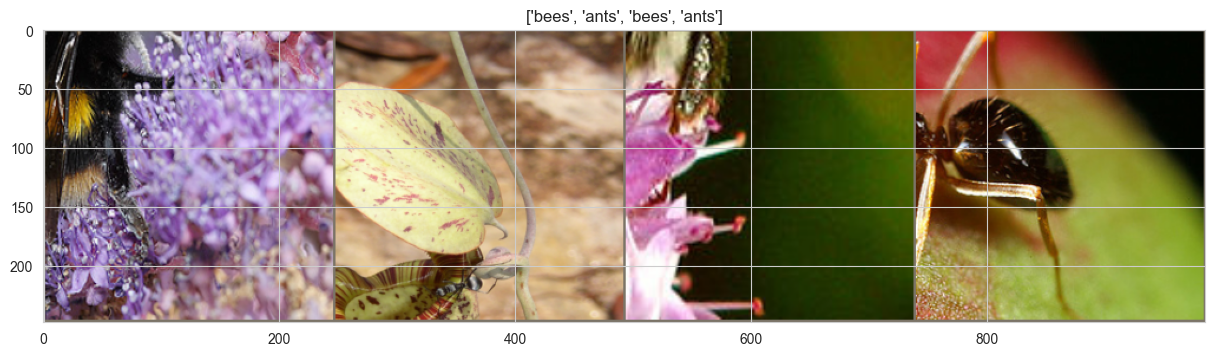

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[ 2.0434,  2.0263,  2.0263,  ...,  1.5125,  0.9817,  0.4851],
         [ 2.0434,  2.0263,  2.0263,  ...,  1.4612,  1.2728,  1.2385],
         [ 2.0263,  2.0263,  2.0434,  ...,  1.1872,  1.0159,  1.0331],
         ...,
         [ 1.9578,  1.9235,  1.8893,  ...,  1.6324,  1.7180,  1.6667],
         [ 1.9407,  1.8893,  1.8722,  ...,  1.5982,  1.6495,  1.5810],
         [ 1.9064,  1.9064,  1.8722,  ...,  1.5468,  1.5125,  1.4612]],

        [[ 2.0784,  2.0609,  2.0784,  ...,  0.9755,  0.4328, -0.0049],
         [ 2.0784,  2.0609,  2.0784,  ...,  0.9755,  0.7479,  0.6779],
         [ 2.0609,  2.0609,  2.0784,  ...,  0.6954,  0.4328,  0.4153],
         ...,
         [ 1.2381,  1.1856,  1.1506,  ...,  1.0630,  1.1681,  1.1506],
         [ 1.2031,  1.1506,  1.1331,  ...,  1.0455,  1.0980,  1.0455],
         [ 1.1681,  1.1681,  1.1331,  ...,  1.0105,  0.9930,  0.9580]],

        [[-1.7696, -1.7870, -1.8044,  ..., -1.6302, -1.6650, -1.7522],
         [-1.7696, -1.7870, -1.8044,  ..., -1

### Обучение моделей

Следующая функция будет использоваться для обучения модели. Аргументы:
* model $-$ нейросеть
* loss $-$ оптимизируемая функция (criterion, cost function, objective)
* optimizer $-$ оптимизационный алгоритм
* scheduler $-$ политика изменения learning_rate
* num_epochs $-$ количество итераций обучения

**Задание**: Вам нужно модифицировать эту функцию, чтобы она возвращала ещё и массивы loss'а на обучающей и валидационной выборках (чтобы потом Вы могли нарисовать графики). Можете модифицировать эту функцию как угодно, лишь бы она правильно работала.

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Ваш код здесь
            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

Функция для отрисовки тестовых изображений и предсказаний для них:

In [9]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Функция для измерения точности модели на валидационном датасете

In [10]:
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

### Задание

Для каждой из следующих нейросетей:
* **AlexNet** (уже сделано в примере)
* **VGG16**
* **Inception_v3**

Напишите код и выведите результат (график лосса, accuracy и вывод примера классификации картинок с визализацией (с помощью функции `vizualize_model()`)) для трёх способов:
* Использование готовой нейросети **"из коробки"**
* Использование нейросети как **Feature Extractor**
* **Fine Tuning** нейросети

Для каждого пункта нужно:
* сделать с сетью то, что нужно в пункте ("из коробки", FE или FT)
* вывести график loss'а на обучающей и на валидационной выборке
* вывести качество модели (accuracy) на валидационной (тестовой) выборке
* (по желанию) использовать функцию visualize_model()

<h2 style="text-align: center;"><b>AlexNet</b></h2>

**AlexNet** - нейронная сеть, которая победила в ILSVRC (соревнование по классификации картинок из ImageNet) в 2012 году и стала основой для многих других архитектур. Впервые она была представлена в статье  “ImageNet Classification with Deep Convolutional Neural Networks”, над которой работал Джоффри Хинтон - человек, которого многие называют отцом современного computer vision.

Архитектура описана на картинке ниже

<img src="https://camo.githubusercontent.com/0002c19acb497b3c5b69588ac78970fd2e2b5bdbae6478efafb3fa686d78924b/68747470733a2f2f7777772e6c6561726e6f70656e63762e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30352f416c65784e65742d312e706e67">

**AlexNet** состоит из 5 **сверточных** слоев, 3 **MaxPool** слоев и 2 **FullyConnected** слоев в конце. Обратите внимание, что в последнем пулинг слое окна, из которых берется максимум, пересекаются за счет того, что *stride*=2. Это изменение по сравнению с традиционным пулингом помогло снизить ошибку на 0.4%.

По сути **AlexNet** это самая базовая архитектура для сверточной сети после LeNet, которую мы уже писали на предыдущем занятии.

*ПРИМЕЧАНИЕ: Здесь не выведены графики loss'а и не использована visualize_model(). От Вас это ожидается.*

Загрузка модели:

In [11]:
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

Посмотрим, что внутри:

In [12]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Видим, что на вход классификатору (classifier) подаётся *9216 признаков*. Это и будет размер входа для нашего нового классификатора.

## Fine Tuning способ
Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:
(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

In [13]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]/Users/mitya/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

val Loss: 0.0938 Acc: 0.8954: 100%|██████████| 25/25 [15:33<00:00, 37.35s/it]  

Training complete in 15m 34s
Best val Acc: 0.901961


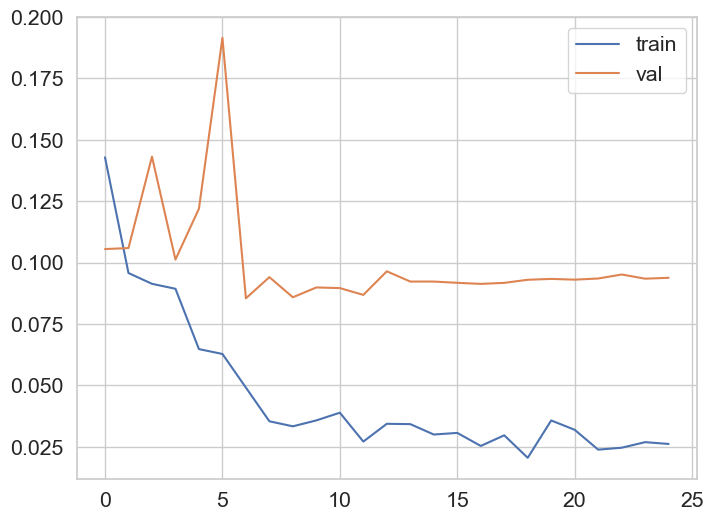

In [15]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(8, 6))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [17]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [18]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.8954


### Feature Extractor способ:

In [19]:
model_extractor = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

Помним, что по-умолчанию все слои нейросети обучаются заново:

In [20]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Сделаем так, чтобы на них *не распространялся backpropagation* (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [21]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

val Loss: 0.0904 Acc: 0.8889: 100%|██████████| 25/25 [12:16<00:00, 29.48s/it]  

Training complete in 12m 17s
Best val Acc: 0.895425
CPU times: user 8min 27s, sys: 14.9 s, total: 8min 42s
Wall time: 12min 16s


In [23]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [24]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [25]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.8889


Видим, что качество намного лучше: ~90%.

### Смешанный способ:
Мы будем обучать не только последний **fully connected** слой, но и несколько предпоследних

In [26]:
model_mixed = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

In [27]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] +
                      list(model_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

val Loss: 0.0805 Acc: 0.9085: 100%|██████████| 25/25 [13:23<00:00, 32.14s/it]  

Training complete in 13m 24s
Best val Acc: 0.921569
CPU times: user 11min 40s, sys: 32 s, total: 12min 12s
Wall time: 13min 23s


In [29]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')

In [30]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))

<All keys matched successfully>

In [31]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))

Accuracy: 0.9085


**Вопрос 1 (важный):** С чем связано повышение качества если мы перестаем учить всю сеть? (Подсказка: посмотрите на датасет и на то, как он согласуется с 4-мя ситуациями, описанными выше)

**Ответ (важный):** <Ваш ответ>

**Вопрос 2**: Почему разморозка последних слоев не дает прироста к точности, хотя разморозить несколько послдних слоев обычно хорошеее решение для классификации похожего датасета? (Вопрос на внимательность)

**Ответ:** <Ваш ответ>

## Еще один метод

Можно не замораживать все первые слои, а делать так, чтобы шаг градиента на них был меньше. Интерфейс оптимизатора позволяет это делать.

In [ ]:
model_diff_lr = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

model_diff_lr.classifier = nn.Linear(num_features, 2)

optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.features.parameters(), "lr": 1e-5,}
    ],
    lr=1e-4
)

criterion = nn.CrossEntropyLoss()


# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_diff_lr.to("cuda")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=2, bias=True)
)

In [ ]:
_, losses = train_model(model_diff_lr, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_diff_lr)))

Accuracy: 0.9150


### Другие, более современные нейросети

**Вопрос:** Какую стратегию Вы выберете, учитывая размер и специфику нового датасета?

**Ответ:** <Ваш ответ>

### VGG16

Один **сверточный** слой с фильтром 5$\times$5 можно заменить двумя подряд идущими слоями с фильтрами размером 3$\times$3, так как **воспринимаемая область** картинки у них будет одинаковой. При этом уменьшиться количество параметров, поэтому такую сеть будет легче обучать.

На момент создания VGG люди уже заметили, что чем больше слоев в нейросети, тем выше ее точность. Заменяя большие фильтры на несколько фильтров 3$\times$3 исследователи получили глубокую нейросеть с меньшим количеством параметров. Архитектура VGG-16 (версии VGG с 16 слоями) представлена на картинке ниже:

<img src="https://camo.githubusercontent.com/a0527fc25cd3c8c68a27cbae3c005de7eef77e6251c754faeda3b972047285ce/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313034302f312a30546b344a636c68474f43525f754c6536524b7655512e706e67">

Когда говорят **VGG**, то чаще всего имеют ввиду **VGG-16** или **VGG-19**. Более глубоких версий **VGG** нет, так как после 19 слоев точность начинает падать.

Чтобы добиться высоких результатов в соревновании при обучении и валидации нейросети использовались дополнительные премы, подробнее о которых можно прочитать в [статье на Medium](https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11).

In [ ]:
# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
# Запустите обучение

model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

In [ ]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9542


### Inception_v3

### Рассмотрим идею, которая подтолкнула исследователей к созданию этой архитектуры.

Площадь, которую занимает классифицируемый объект, может очень сильно отличаться. Пример на картинке ниже:

<img src="https://camo.githubusercontent.com/398fd1b75d2c184831beae888f1cb60783eb39e20d2168b13707afdcd09aff48/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313034302f312a614264504247416574612d5f414d34614579716554512e6a706567">


* Для извлечения информации с большой площади лучше всего подходят **большие** фильтры, и наоборот для маленьких объектов лучше **маленькие** фильтры.
* Глубокие нейронные сети намного сложнее обучать: в них появляется проблема **затухания градиента** и они **переобучаются**.
Чтобы решить первую проблему исследователи придумали **Incepton** модуль, который применяет фильтры разного размера и затем склеивает полученные каналы. При этом извлекается как информация из больших объектов, так и из маленьких. Простейшая реализация модуля выглядит так:
<img src="https://camo.githubusercontent.com/4946a8fffc338bcfe638fc22d9ce6f8ea2ea7fd2f47be6b83bb5d6a233cb5953/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313034302f312a444b6a475244645f6c4a655566566c5935306f6a4f412e706e67">

Реализацию можно сделать более эффективной, если сначала уменьшить количество каналов с помощью **сверточного слоя** 1$\times$1 и лишь затем применить **слой** с фильтрами 5$\times$5. Сокращение вычислений происходит за счет того, что мы сначала **уменьшаем размерность** данных и лишь затем преобразовываем их. Продвинутая реализация:
<img src="https://camo.githubusercontent.com/3999a741ff4a4c97026164d86200a5504b2fdc82fc9b76d9d3e1808c20df7390/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313034302f312a555f4d634a6e7037466e69662d6c77396949433542772e706e67">

Сеть состоит из **корня** (нескольких сверточных слоев) и **Inception** модулей идущих за ним. Оранжевым прямоугольников выделен корень, а фиолетовыми - **вспомогательные классификаторы**. Именно они помогают бороться со второй проблемой, которую мы упомянули ранее. Наша функция потерь - взвешенная сумма **LogLoss** на двух **вспомогательных классификаторах** и **основном** в конце нейронной сети.
<img src="https://cdn-images-1.medium.com/max/1040/1*uW81y16b-ptBDV8SIT1beQ.png">

После Inception v1 были представлены 2, 3 и 4 версии, пррочитать о которых вы можете  в [статье на Medium](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202).

In [ ]:
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.

# Результирующий размер картинок определяется трансформациями
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [ ]:
model_extractor = models.inception_v3(pretrained=True)

In [ ]:
model_extractor.AuxLogits.fc = nn.Linear(768, 2)
model.fc = nn.Linear(2048, 2)

In [ ]:


# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

In [22]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')

NameError: name 'model_extractor' is not defined

In [23]:
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

NameError: name 'model_extractor' is not defined

In [24]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

NameError: name 'model_extractor' is not defined

**Вопрос:** Какая из сетей оказалась наилучшей? Как думаете, почему?

**Ответ:** <Ваш ответ>

### Resnet

Следующая илея касается проблемы затухания градиентов. Чем больше слоев, тем хуже они проходят при backprop.

$$
\frac{\partial F}{\partial w_1} \times \frac{\partial F}{\partial w_2} \times \dots \times\frac{\partial F}{\partial w_n}
$$

Поэтому мы как бы можем прокидывать их в более глубокие слои с помощью residual соединений. А значит можем делать сети ГЛУБЖЕ...

![](https://www.machinelearningmastery.ru/img/0-145407-381989.png)

### ResNext

<a href="https://github.com/DLSchool/deep-learning-school/blob/fall_2021_part1/09_Image_classification/%5Bseminar%5Dtransfer_learning_%5Bremastered_2021%5D.ipynb">тут с картинками</a>

Но здесь мы сталкиваемся с проблемой. Мы снова получили лишь один путь для фичей. Давайте попробуем в некотором роде обхединить идеи последних двух пунктов.

<img src='https://camo.githubusercontent.com/9ce24664a02cf02bf2b97c954a495e584de59262899261c71d4fdf0336552c43/68747470733a2f2f7777772e70726f6772616d6d6572736f756768742e636f6d2f696d616765732f3935352f31396361383238346661666564393063646662646339623130336165303634622e706e67'/>

Итак введем еще одну размерность -- число путей. В оригинальной она называется coordinality.

$\mathcal{F}(\mathbf{x})=\sum_{i=1}^{C} \mathcal{T}_{i}(\mathbf{x})$

Теперь давайте думать, как можно оптимизировать такую архитектуру с точки зрения вычислений.

![](https://miro.medium.com/max/1000/1*cIm3uy7eNvEchxRbBeBScQ.png)

Картинка сверху очень содержательная. Все три блока на самом деле эквивалентны с точки зрения математики. Итак, давайте посмотрим на переход (a) -> (b):
Вместо того, чтобы складывать большие тензоры в конце, давайте просто конкатенировать по размерности каналов маленькие. А затем уже применим свертку 1х1 один раз.

(b) -> (c):

Второй переход потребует от нас чуть больше ментальных усилий. Для начал разберемся, что такое group-свертка. В обычном сверточном слое происходит следующее:

![](https://blog.yani.ai/assets/images/posts/2017-08-10-filter-group-tutorial/convlayer.svg)

Серым изображены тензоры фичей до и после свертки, а желтым -- сами ядра сверток, при этом одна "полоска" этих сверток соответствует одному каналу выходного тензора. Таким образом у нас в каждой полоске $c_1$ сверток, а полосок всего $c_2$. Число параметров в таком случае $N_1 = c_1 \cdot c_2$.

Запомним это число.

Теперь давайте разделим входной и выходной тензор на две части:

![](https://blog.yani.ai/assets/images/posts/2017-08-10-filter-group-tutorial/filtergroups2.svg)

Теперь давайте попытаемся перевести первую половинку входного тензора в первую половинку выходного. Для этого нам понадобится $c_2 / 2$ "полосок" длинной $c_1 / 2$. Проделаем то же самое с оставшимися половинками. А теперь магия: сколько в итоге праметров мы получим? $N_2 = 2\cdot(c_1/2 \cdot c_2/2) < c_1\cdot c_2 = N_1$.

[Про group-свертки.](https://blog.yani.ai/filter-group-tutorial/)

[Оригинальная cтатья про ResNeXT](https://https://arxiv.org/pdf/1611.05431.pdf)




## Efficient Net



Движемся дальше. Поговорим об эффективности более подробно. До этого архитектуры сетей, можно сказать, подбирались руками. Так у нас есть ResNet50, а не ResNet54 со свертками 3x3 а не 4x4.

Но если у нас есть достаточно ресурсов, то можно попробовать обучить алгоритм, который будет подбирать правильные параметры для слоев. Для начала нужно определить какие бывают методы для увеличения сети и запустить по ним grid search:

![](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s640/image4.png)

Затем основываясь на основе этих данны можно получить оптимальную архитектуру длясвоего числа параметров

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png)

И оказывается, что даже самая маленькая сеть будет показывать лучшие результаты.

![](https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png)

Подробнее [здесь](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html).

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')


<h2 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *cs231n: http://cs231n.github.io/transfer-learning/*

2). *Туториал на PyTorch Tutorials: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial*

3). *Статья на Medium про TL в PyTorch: https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4*